<a href="https://colab.research.google.com/github/rezamohammadloo/Surface_anomaly_detection_using_unsupervised_algorithms/blob/main/SurfaceDefectDetectionUsingVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount Google Drive

In [1]:
# Mount Google Drive to access files stored in my Google Drive account
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Import TensorFlow and Other Libraries

In [2]:
# Import TensorFlow and necessary libraries for building and training the VAE
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
import numpy as np
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img

Load Images from Directory

In [3]:
# Define a function to load images from a specified directory and resize them to the target size
def load_images_from_directory(directory, target_size=(128, 128)):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith('.png') or filename.endswith('.jpg'):
            img = load_img(os.path.join(directory, filename), target_size=target_size)
            img_array = img_to_array(img) #/ 255.0
            images.append(img_array)
    return np.array(images)

# Directories
# Specify the directories containing normal, anomaly, and mask images
normal_dir = '/content/gdrive/MyDrive/glass-defect-sample/good'
anomaly_dir = '/content/gdrive/MyDrive/glass-defect-sample/anomaly'
mask_dir = '/content/gdrive/MyDrive/glass-defect-sample/mask'

# Load data
# Load the normal, anomaly, and mask images from their respective directories
normal_images = load_images_from_directory(normal_dir)
anomaly_images = load_images_from_directory(anomaly_dir)
mask_images = load_images_from_directory(mask_dir)

# Normalize images
# Normalize the pixel values of the loaded images to the range [0, 1]
normal_images = normal_images / 255.0
anomaly_images = anomaly_images / 255.0
mask_images = mask_images / 255.0

In [4]:
latent_dim = 32

# Encoder
def encoder_model(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    return models.Model(inputs, [z_mean, z_log_var], name='encoder')

# Sampling layer
def sampling(args):
      # Define the sampling function to sample from the learned distribution
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Decoder
def decoder_model(latent_dim, input_shape):
      # Define the decoder architecture
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense((input_shape[0] // 8) * (input_shape[1] // 8) * 128, activation='relu')(latent_inputs)
    x = layers.Reshape((input_shape[0] // 8, input_shape[1] // 8, 128))(x)
    x = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    outputs = layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)
    return models.Model(latent_inputs, outputs, name='decoder')

# Define input shape
input_shape = (128, 128, 3)
# Build the encoder
encoder = encoder_model(input_shape)
z_mean, z_log_var = encoder.output
z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
decoder = decoder_model(latent_dim, input_shape)
outputs = decoder(z)

# VAE model
vae = models.Model(encoder.input, outputs, name='vae')

In [5]:
# Calculate the reconstruction loss using binary cross-entropy
reconstruction_loss = tf.keras.losses.binary_crossentropy(K.flatten(encoder.input), K.flatten(outputs))
# Scale the reconstruction loss based on the input shape
reconstruction_loss *= input_shape[0] * input_shape[1] * input_shape[2]

# Calculate the KL divergence loss
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

# Calculate the total VAE loss by combining the reconstruction and KL divergence losses
vae_loss = K.mean(reconstruction_loss + kl_loss)

# Add the VAE loss to the model
vae.add_loss(vae_loss)

# Compile the VAE model with the Adam optimizer
vae.compile(optimizer='adam')


In [6]:
# Import the EarlyStopping callback from TensorFlow
EarlyStopping = tf.keras.callbacks.EarlyStopping

# Define the history object to store training metrics
history = vae.fit(
    # Train the VAE model on normal images with normal images as both input and target
    normal_images, normal_images,
    epochs=500,  # Number of epochs for training
    batch_size=32,  # Batch size for training
    validation_split=0.2,  # Fraction of training data to use for validation
    callbacks=EarlyStopping(  # Early stopping callback to prevent overfitting
        monitor="val_loss",  # Monitor validation loss
        verbose=1,  # Verbosity mode (1: progress bar, 0: silent)
        patience=6,  # Number of epochs with no improvement after which training will be stopped
        mode='min',  # Direction of improvement (minimize validation loss)
        restore_best_weights=True  # Restore the model weights from the epoch with the best validation loss
    )
)


Epoch 1/500
4/4 [==============================] - 14s 727ms/step - loss: 43281.5195 - val_loss: 26895.0801
Epoch 2/500
4/4 [==============================] - 0s 47ms/step - loss: 28235.4727 - val_loss: 31647.6191
Epoch 3/500
4/4 [==============================] - 0s 47ms/step - loss: 31775.7871 - val_loss: 31652.1289
Epoch 4/500
4/4 [==============================] - 0s 48ms/step - loss: 30951.3789 - val_loss: 29421.3848
Epoch 5/500
4/4 [==============================] - 0s 56ms/step - loss: 26522.7754 - val_loss: 26539.8652
Epoch 6/500
4/4 [==============================] - 0s 52ms/step - loss: 25571.9551 - val_loss: 24487.9180
Epoch 7/500
4/4 [==============================] - 0s 47ms/step - loss: 24652.4570 - val_loss: 25430.1309
Epoch 8/500
4/4 [==============================] - 0s 46ms/step - loss: 24401.7520 - val_loss: 24796.7676
Epoch 9/500
4/4 [==============================] - 0s 52ms/step - loss: 24182.3262 - val_loss: 24482.3301
Epoch 10/500
4/4 [==========================

In [7]:
# Reconstruct normal and anomaly images using the trained VAE model
reconstructed_normal = vae.predict(normal_images)
reconstructed_anomaly = vae.predict(anomaly_images)

# Define a function to compute reconstruction errors
def compute_reconstruction_error(original, reconstructed):
    return np.mean(np.abs(original - reconstructed), axis=(1, 2, 3))

# Compute reconstruction errors for normal and anomaly images
normal_errors = compute_reconstruction_error(normal_images, reconstructed_normal)
anomaly_errors = compute_reconstruction_error(anomaly_images, reconstructed_anomaly)

# Print mean reconstruction errors for normal and anomaly images
print("Mean reconstruction error for normal images:", np.mean(normal_errors))
print("Mean reconstruction error for anomalous images:", np.mean(anomaly_errors))

2/2 [==============================] - 0s 447ms/step
Mean reconstruction error for normal images: 0.044666532
Mean reconstruction error for anomalous images: 0.14031217


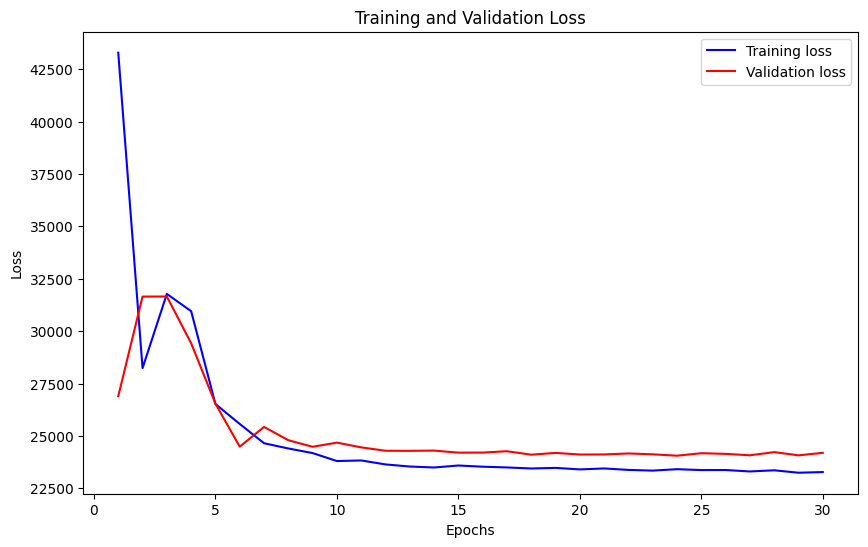

In [8]:
import matplotlib.pyplot as plt

# Extract the loss and validation loss from the training history
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss and validation loss
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'b', label='Training loss')  # Plot training loss
plt.plot(epochs, val_loss, 'r', label='Validation loss')  # Plot validation loss
plt.title('Training and Validation Loss')  # Set plot title
plt.xlabel('Epochs')  # Set x-axis label
plt.ylabel('Loss')  # Set y-axis label
plt.legend()  # Display legend
plt.show()  # Show plot


In [12]:
from sklearn.metrics import roc_auc_score, average_precision_score

# Combine the reconstruction errors and true labels
all_errors = np.concatenate([normal_errors, anomaly_errors])
true_labels = np.concatenate([np.zeros(len(normal_errors)), np.ones(len(anomaly_errors))])

# Define a threshold to classify anomalies based on reconstruction errors
threshold = np.mean(all_errors)  # Adjust this threshold based on your specific use case

# Predict labels based on the threshold
predicted_labels = (all_errors > threshold).astype(int)


# Calculate AUC-ROC
auc_roc = roc_auc_score(true_labels, all_errors)
print(f"AUC-ROC: {auc_roc}")

# Calculate Average Precision (AP)
average_precision = average_precision_score(true_labels, all_errors)
print(f"Average Precision (AP): {average_precision}")



AUC-ROC: 0.9191082802547771
Average Precision (AP): 0.8295025760780391
